<a href="https://colab.research.google.com/github/hanghae-plus-AI/AI-1-JunYear/blob/main/week%202/%5B2%EC%A3%BC%EC%B0%A8%5D_%EA%B3%BC%EC%A0%9C_B_%EC%A3%BC%EC%96%B4%EC%A7%84_%EB%AC%B8%EC%9E%A5%EC%97%90_%EB%82%98%EC%98%AC_%EB%8B%A4%EC%9D%8C_%EB%8B%A8%EC%96%B4_%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8_%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install sacremoses

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 32.5 MB/s eta 0:00:00


In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.5 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.


# (목표) Last word prediction dataset 준비
  - 기존의 IMDB dataset을 그대로 활용합니다.
  - `collate_fn` 함수에 다음 수정사항들을 반영하면 됩니다.
      - Label은 text를 token으로 변환했을 때 마지막에서 두 번째 token의 id로 설정합니다.
      - 입력 data는 마지막 두 token을 제외한 나머지 token들의 list로 설정합니다.
  - `from torch.nn.utils.rnn import pad_sequence`를 import해서 사용하셔도 좋습니다.
  - Truncation은 기존과 똑같이 진행하시면 됩니다.

In [3]:
import torch
from datasets import load_dataset

from torch.nn.utils.rnn import pad_sequence

from torch.utils.data import DataLoader
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


ds = load_dataset("stanfordnlp/imdb")
tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')


def collate_fn(batch):
  max_len = 400
  texts, labels = [], []

  for row in batch:
    tokens = tokenizer(
        row['text'],
        padding=False,
        truncation=True,
        max_length=max_len
    )
    input_ids = tokens.input_ids

    if len(input_ids) < 3:
      continue

    ## Label은 text를 token으로 변환했을 때 마지막에서 두 번째 token의 id로 설정
    labels.append(input_ids[-2])
    texts.append(torch.tensor(input_ids[:-2], dtype=torch.long))


  #texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
  texts = pad_sequence(
      texts,
      batch_first=True,
      padding_value=tokenizer.pad_token_id
  )
  labels = torch.LongTensor(labels)

  return texts, labels

batch_size=64

train_loader = DataLoader(
    ds['train'], batch_size=batch_size, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    ds['test'], batch_size=batch_size, shuffle=False, collate_fn=collate_fn
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/huggingface/pytorch-transformers/zipball/main" to /root/.cache/torch/hub/main.zip


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [4]:
ds['train'][0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

# Self-Attention

In [5]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

# [완] (준비) Multi-head Attention 구현
> Self-attention module을 MHA로 확장해주시면 됩니다. 여기서 MHA는 다음과 같이 구현합니다.

- [ ] 기존의 $W_q, W_k, W_v$를 사용하여 $Q, K, V$를 생성합니다. **이 부분은 코드 수정이 필요 없습니다.**
- [x] $Q, K, V \in \mathbb{R}^{S \times D}$가 있을 때, 이를 $Q, K, V \in \mathbb{R}^{S \times H \times D’}$으로 reshape 해줍니다. 여기서 $H$는 `n_heads`라는 인자로 받아야 하고, $D$가 $H$로 나눠 떨어지는 값이여야 하는 제약 조건이 필요합니다. $D = H \times D’$입니다.
- [x] $Q, K, V$를 $Q, K, V \in \mathbb{R}^{H \times S \times D’}$의 shape으로 transpose해줍니다.
- [ ] $A = QK^T/\sqrt{D'} \in \mathbb{R}^{H \times S \times S}$를 기존의 self-attention과 똑같이 계산합니다. **이 부분은 코드 수정이 필요 없습니다.**
- [x] Mask를 더합니다. 기존과 $A$의 shape이 달라졌기 때문에 dimension을 어떻게 맞춰줘야할지 생각해줘야 합니다.
- [x] $\hat{x} = \textrm{Softmax}(A)V \in \mathbb{R}^{H \times S \times D'}$를 계산해주고 transpose와 reshape을 통해 $\hat{x} \in \mathbb{R}^{S \times D}$의 shape으로 다시 만들어줍니다.
- [ ] 기존과 똑같이 $\hat{x} = \hat{x} W_o$를 곱해줘서 마무리 해줍니다. **이 또한 코드 수정이 필요 없습니다.**

ref.
- [딥러닝을 이용한 자연어 처리 입문, wikidocs](https://wikidocs.net/103802)
- [Transformer (Multi-head Attention), codingopera.tistory](https://codingopera.tistory.com/44)

In [6]:
from torch import nn
from math import sqrt

class MultiHeadAttention(nn.Module):
  def __init__(self, input_dim, d_model, n_heads):
    super().__init__()

    self.input_dim = input_dim  # 입력 임베딩 차원
    self.d_model = d_model      # 모델 임베딩 차원 (전체 어텐션 차원)
    self.n_heads = n_heads      # 어텐션 해드 수

    ## 제약조건: d_model이 n_heads로 나누어 떨어져야 함
    '''
    if d_model % n_heads == 0:
        self.depth = d_model // n_heads  # D' = D / H
    else:
        raise ValueError(f"d_model {d_model}은 n_heads {n_heads}로 나누어 떨어져야 합니다.")
     '''
    assert d_model % n_heads == 0, "d_model must be divisible by num_heads"
    self.depth = d_model // n_heads  # D' = D / H

    # 가중치 행렬 정의
    self.wq = nn.Linear(input_dim, d_model)       # (B, S, D)
    self.wk = nn.Linear(input_dim, d_model)       # (B, S, D)
    self.wv = nn.Linear(input_dim, d_model)       # (B, S, D)

    self.dense = nn.Linear(d_model, d_model)      # (B, S, D)

    self.softmax = nn.Softmax(dim=-1)


  def split_heads(self, x):
    """
     - 해당 함수는 입력 x를 (B, S, H, D')로 변환하고 차원을 교환하며 (B, H, S, D')로 변환한다.
    Args:
      x: 텐서 (B, S, D)
    Returns:
      (B, H, S, D')
    """

    batch_size, seq_len, _ = x.size()

    x = x.view(batch_size, seq_len, self.n_heads, self.depth)   # (B, S, H, D')
    x = x.transpose(1, 2)                                       # (B, H, S, D')

    return x

  def forward(self, x, mask=None):
    """
    Args:
        x: 입력 텐서 (B, S, input_dim)
        mask: 마스크 텐서 (B, S, S)

    Returns:
        출력 텐서 (B, S, d_model)
    """

    batch_size, seq_len, _ = x.size()

    # Q, K, V 계산
    q, k, v = self.wq(x), self.wk(x), self.wv(x)    # (B, S, D)

    # 헤드 분할 및 차원 변환
    q = self.split_heads(q)                         # (B, H, S, D')
    k = self.split_heads(k)                         # (B, H, S, D')
    v = self.split_heads(v)                         # (B, H, S, D')

    # Scaled Dot-Product Attention
    # 어텐션 스코어 계산
    score = torch.matmul(q, k.transpose(-1, -2))    # (B, H, S, D') * (B, H, D', S) = (B, H, S, S)
    score = score / sqrt(self.depth)

    # 마스크 적용
    if mask is not None:
        mask = mask.unsqueeze(1)  # (B, 1, S, S), 헤드 차원에 맞게 확장
        score = score.masked_fill(mask == 0, -1e9)  # 마스크 위치에 큰 음수 값 채워넣기

    # 어텐션 가중치 계산
    attn_weights = self.softmax(score)              # (B, H, S, S)

    # 어텐션 출력 계산
    attn_output = torch.matmul(attn_weights, v)     # (B, H, S, D')

    # 헤드 결합
    attn_output = attn_output.transpose(1, 2)       # (B, S, H, D')
    attn_output = attn_output.contiguous().view(batch_size, seq_len, self.d_model)  # (B, S, D)

    # 최종 선형 변환
    result = self.dense(attn_output)                # (B, S, D)

    return result

# [완] (목표) Layer normalization, dropout, residual connection 구현

> 다시 `TransformerLayer` class로 돌아와서 과제를 진행하시면 됩니다.

- [x] Attention module을 $MHA$, feed-forward layer를 $FFN$이라고 하겠습니다. 다음과 같이 수정해주시면 됩니다.

```python
# x, mask is given

x1 = MHA(x, mask)
x1 = Dropout(x1)
x1 = LayerNormalization(x1 + x)

x2 = FFN(x1)
x2 = Dropout(x2)
x2 = LayerNormalization(x2 + x1)

return x2
```
   
- 여기서 `x1 + x`와 `x2 + x1`에 해당하는 부분들은 residual connection이라고 부릅니다.


In [7]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, n_heads, dff, dropout_rate=0.1):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff
    self.n_heads = n_heads

    # Multi-Head Attention Layer
    self.mha = MultiHeadAttention(
        input_dim,
        d_model,
        n_heads
    )

    # Feed-Forword Network Layer
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

    # Dropout Layer
    self.dropout1 = nn.Dropout(dropout_rate)
    self.dropout2 = nn.Dropout(dropout_rate)

    # Layer Normalization Layer
    self.layernorm1 = nn.LayerNorm(d_model)
    self.layernorm2 = nn.LayerNorm(d_model)

  def forward(self, x, mask):
    """
    Args:
        x: 입력 텐서 (batch_size, seq_len, input_dim)
        mask: 마스크 텐서 (batch_size, seq_len, seq_len)

    Returns:
        출력 텐서 (batch_size, seq_len, d_model)
    """

    # Multi-Head Attention
    x1 = self.mha(x, mask)         # (batch_size, seq_len, d_model)
    x1 = self.dropout1(x1)
    x1 = self.layernorm1(x + x1)   # Residual Connection

    # Feed-Forward Network
    x2 = self.ffn(x1)              # (batch_size, seq_len, d_model)
    x2 = self.dropout2(x2)
    x2 = self.layernorm2(x1 + x2)  # Residual Connection

    return x2

# Positional encoding

Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [8]:
import numpy as np

def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  pos_encoding = angle_rads[None, ...]

  return torch.FloatTensor(pos_encoding)

max_len = 400
print(positional_encoding(max_len, 256).shape)

torch.Size([1, 400, 256])


# [완] (목표) 5-layer 4-head Transformer

- [x] 기존 실습에서 사용한 hyper-parameter들과 위에서 구현한 Transformer를 가지고 5-layer 4-head Transformer의 성능 결과를 report해주시면 됩니다.

# (목표) Loss function 및 classifier output 변경
- 마지막 token id를 예측하는 것이기 때문에 binary classification이 아닌 일반적인 classification 문제로 바뀝니다.
- MNIST 과제에서 했던 것 처럼 `nn.CrossEntropy loss`와 `TextClassifier`의 출력 차원을 잘 조정하여 task를 풀 수 있도록 수정하시면 됩니다.

In [9]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, n_heads):
    super().__init__()

    self.vocab_size = vocab_size
    self.d_model = d_model
    self.n_layers = n_layers
    self.dff = dff

    self.embedding = nn.Embedding(vocab_size, d_model)
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, n_heads, dff) for _ in range(n_layers)])
    self.classification = nn.Linear(d_model, vocab_size)  ## 일반적인 classification 결과 출력

  def forward(self, x):
    mask = (x == tokenizer.pad_token_id)
    mask = mask[:, None, :]
    seq_len = x.shape[1]

    x = self.embedding(x)
    x = x * sqrt(self.d_model)
    x = x + self.pos_encoding[:, :seq_len]

    for layer in self.layers:
      x = layer(x, mask)

    x = x[:, -1]
    x = self.classification(x)

    return x


model = TextClassifier(len(tokenizer), 32, 5, 32, 4)

# 모델 훈련

In [10]:
from torch.optim import Adam

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()

optimizer = Adam(model.parameters(), lr=lr)

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    outputs = model(inputs)
    # preds = torch.argmax(preds, dim=-1)
    # preds = (preds > 0).long()[..., 0]
    preds = torch.argmax(outputs, dim=1)


    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [12]:
n_epochs = 50

train_acc_list = []
test_acc_list = []

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    outputs = model(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)

Epoch   0 | Train Loss: 1542.5912206172943
=========> Train acc: 0.561 | Test acc: 0.563
Epoch   1 | Train Loss: 1046.9844522476196
=========> Train acc: 0.576 | Test acc: 0.578
Epoch   2 | Train Loss: 999.0216519832611
=========> Train acc: 0.580 | Test acc: 0.579
Epoch   3 | Train Loss: 968.19093978405
=========> Train acc: 0.583 | Test acc: 0.581
Epoch   4 | Train Loss: 937.8890058994293
=========> Train acc: 0.586 | Test acc: 0.583
Epoch   5 | Train Loss: 907.4968255758286
=========> Train acc: 0.589 | Test acc: 0.579
Epoch   6 | Train Loss: 875.9052636623383
=========> Train acc: 0.595 | Test acc: 0.582
Epoch   7 | Train Loss: 846.6327352523804
=========> Train acc: 0.602 | Test acc: 0.581
Epoch   8 | Train Loss: 817.2355123758316
=========> Train acc: 0.616 | Test acc: 0.579
Epoch   9 | Train Loss: 788.7630980014801
=========> Train acc: 0.626 | Test acc: 0.580
Epoch  10 | Train Loss: 761.0112100839615
=========> Train acc: 0.637 | Test acc: 0.579
Epoch  11 | Train Loss: 735.5386

# 모델 성능 평가

> 구현 과제: 5-layer 4-head Transformer의 성능 결과를 report

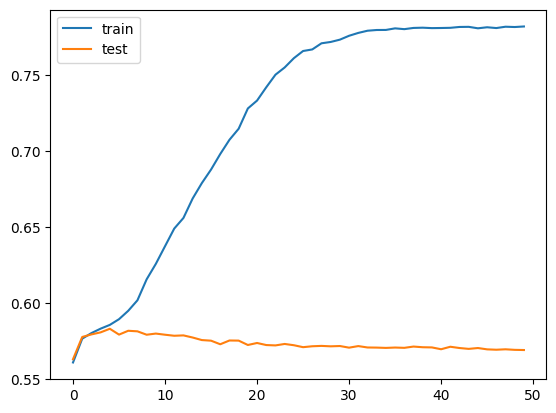

In [13]:
def plot_acc(train_accs, test_accs, label1='train', label2='test'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

plot_acc(train_acc_list, test_acc_list)